## Enumerating Stereoisomers and Tautomers

In this notebook, we'll look at the RDKit's capabilities for enumerating stereoisomers and tautomers.  These functions can enable us to better understand the many forms a molecule can assume in solution.  While these capabilities are powerful, they also need to be used judiciously.  More on that below.

Install the necessary Python libraries.

**Stereoisomers** are compounds with the same molecular formula and the same order of atom connections, but differ in spatial arrangements.

**Tautomers** are isomers that are readily interconvertible for acheiving equilibrium.

In [1]:
%%capture
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !pip install rdkit

In [2]:
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import rdDepictor
from rdkit import IPythonConsole
from rdkit.Chem import EnumerateStereoisomers
from rdkit.Chem.MolStandardize import rdMolStandardize

### Setup
We begin with two settings I always use for Jupyter notebooks with the RDKit.  The first uses vector graphics to draw structures and makes the structure images look better.  The second uses the RDKit's newer, and better, drawing routines.

In [3]:
IPythonConsole.ipython_useSVG = True
rdDepictor.SetPreferCoordGen(True)

### Enumerating Stereoisomers
One factor to consider when selecting compounds for a screening collection is the number of undefined stereocenters. There are two schools of thought on this. Some people don't like to screen compounds with undefined stereocenters. They assert that if you get a hit, you'll have to chirally separate the hit to determine its true activity. Other people like having compounds with undefined stereocenters, they claim that these compounds give them "two for the price of one". I tend to come down somewhere in the middle on this argument. I'll buy compounds with 1 or 2 undefined stereocenters, but won't buy compounds with 3 or more. In this case, the concentration of any one stereoisomer may be too small to give a signal in an assay.

As we remember from the "SMILES Basics" notebook, atom stereochemistry can be represented as "@" or "@@".  Let's start with a pair of molecules having one defined stereocenter.  

**A chiral center, also known as a stereocenter or chiral carbon, is an atom, usually carbon, in a molecule that is bonded to four different groups. If a molecule has at least one chiral center, it is considered chiral, meaning it is not superimposable on its mirror image. Achiral molecules, on the other hand, either lack chiral centers or have chiral centers that are canceled out by symmetry, resulting in a superimposable mirror image**

In [7]:
smi_1 = "F[C@](Cl)(Br)c1ccc(cc1)C(F)(Cl)Br"
mol_1 = Chem.MolFromSmiles(smi_1)
smi_2 = "F[C@@](Cl)(Br)c1ccc(cc1)C(F)(Cl)Br"
mol_2 = Chem.MolFromSmiles(smi_2)


We can put the two molecules into a list and pass the list to the RDKit's [MolsToGridImage](https://www.rdkit.org/docs/source/rdkit.Chem.Draw.html) function to display the structures. Note that each molecule has two stereocenters, but only one of the two is defined. In the figure below, the upper stereocenter is not defined, while the lower is. We can see this because the lower carbon has hashed and wedged bonds, while the upper carbon does not.

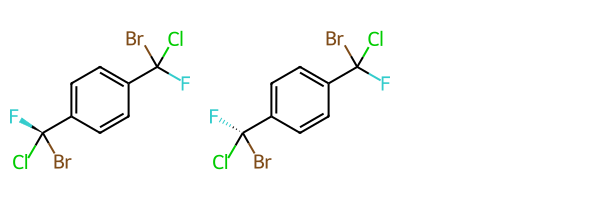

In [8]:
mol_list = [mol_1, mol_2]
MolsToGridImage(mol_list)

The RDKit has a class [EnumerateStereoisomers](https://www.rdkit.org/docs/source/rdkit.Chem.EnumerateStereoisomers.html) that will enumerate all possible stereoisomers for undefined stereocenters.  Let's try this with **mol_1**.

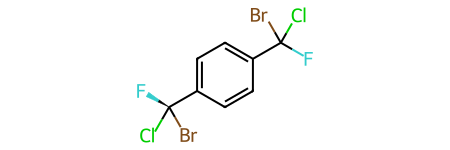

In [11]:
mol_1

Note that enumerate stereoisomers returns a generator object.  To get the stereoisomers we need to iterate over the generator.  One easy way to do this is to use a list comprehension.

In [13]:
EnumerateStereoisomers.EnumerateStereoisomers(mol_1)


<generator object EnumerateStereoisomers at 0x7a2dcfdc4a00>

In [14]:
mol_1_isomer_list = [x for x in EnumerateStereoisomers.EnumerateStereoisomers(mol_1)]
mol_1_isomer_list

Let's look at the stereoisomers.  Note that the lower stereoisomer, which was defined in **mol_1** is the same in both structures, while the upper stereoisomer varies.

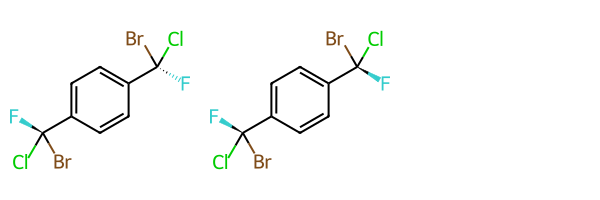

In [15]:
MolsToGridImage(mol_1_isomer_list)

Molecules with undefined chiral centers can give rise to multiple stereoisomers.

If the chiral centers are already defined (R/S specified), the structure represents a specific stereoisomer.

In cheminformatics (e.g., using RDKit), stereoisomers can be generated from a molecule with undefined chirality using Python functions like:
**rdkit.Chem.EnumerateStereoisomers.EnumerateStereoisomers()**

### Labeling Stereoisomers
The RDKit can turn on labeling on [Cahn, Ingold, Prelog (CIP) stereochemistry](https://en.wikipedia.org/wiki/Cahn%E2%80%93Ingold%E2%80%93Prelog_priority_rules) with one command.

R and S configuration describes the absolute 3D arrangement of groups around a chiral center (a carbon bonded to four different atoms or groups).

R (Rectus) = clockwise

S (Sinister) = counterclockwise
Direction is determined using the Cahn-Ingold-Prelog priority rules, with the lowest priority group facing away.

Example:
Consider a carbon bonded to:

–OH

–Cl

–CH₃

–H

Step 1: Assign priorities

Cl (highest atomic number) = 1

OH = 2

CH₃ = 3

H = 4

Step 2: With H (lowest priority) pointing away, trace 1 → 2 → 3

If the direction is:

Clockwise → R

Counterclockwise → S

In [16]:
IPythonConsole.drawOptions.addStereoAnnotation = True

This command enables stereo annotations when drawing molecules — meaning:

➡️ It displays the R/S or E/Z labels next to chiral centers or double bonds when you render a molecule.


Now the stereocenters are labeled as R and S.

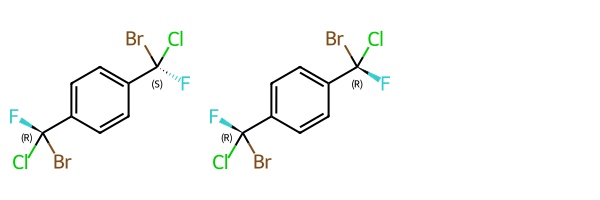

In [17]:
MolsToGridImage(mol_1_isomer_list)

We can also use code to get stereoisomers.

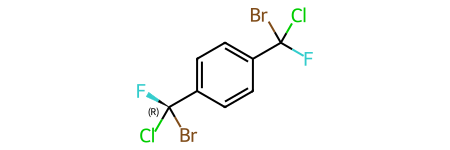

In [18]:
mol_1

Note that atom 1 is **R** but atom 10 is undefined, so the label for atom 10 is **?**.

In [19]:
Chem.FindMolChiralCenters(mol_1,force=True,includeUnassigned=True,useLegacyImplementation=True)

[(1, 'R'), (10, '?')]

At this point, you may be asking, "how do I know which atom is 1 and which atom is 10. Fortunately the RDKit has another convenience function to show atom numbers.

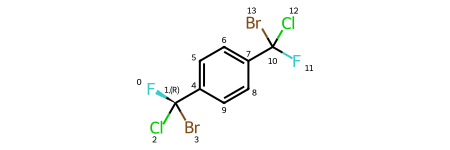

In [20]:
IPythonConsole.drawOptions.addAtomIndices = True
mol_1

We can turn the display of atom numbers off in a similar fashion.

In [21]:
IPythonConsole.drawOptions.addAtomIndices = False

Now lets use a loop to enumerate and label stereoisomers for **mol_1**. Note that, again, the defined stereocenter at atom 1 doesn't change, while the undefined stereocenter at atom 10 is enumerated.

In [22]:
for m in EnumerateStereoisomers.EnumerateStereoisomers(mol_1):
    print(Chem.FindMolChiralCenters(m,force=True,includeUnassigned=True,useLegacyImplementation=False))

[(1, 'R'), (10, 'S')]
[(1, 'R'), (10, 'R')]


### Enumerating Tautomers
Similar to the class **EnumerateStereoisomers** above which enumerates stereoisomers, the RDKit has a class **[rdMolStandardize.TautomerEnumerator](https://www.rdkit.org/docs/source/rdkit.Chem.MolStandardize.rdMolStandardize.html)** that can enumerate tautomers.  Note that this class should be used with caution.  While all the tautomers produced are technically correct, many are non-physical and won't exist in solution.  I've seen people enumerte all the tautomers for every molecule in a virtual screening library prior to docking. **This is an incredibly bad idea!**  If you do this, you'll spend a tremendous amount of time looking through docked structures with non-physical tautomers.  I tend to use tautomer enumeration as a tool to see what's possible.  If I see interesting tautomeric forms, I'll perform quantum chemical calculations to better understand the tautomer energies and distributions.  For a better understanding of tautomers and their impact on protein binding and physical properties, I'd highly recommend Roger Sayle's seminal paper "[So you think you understand tautomerism?](https://link.springer.com/article/10.1007/s10822-010-9329-5)".

To begin, we'll use a typical heterocyclic kinase inhibitor inspired by the pdb structure **[1bmk](https://www.rcsb.org/structure/1BMK)**.

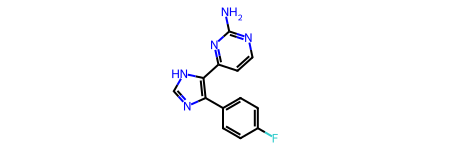

In [23]:
kinase_smi = "Nc1nccc(n1)-c1[nH]cnc1-c1ccc(F)cc1"
kinase_mol = Chem.MolFromSmiles(kinase_smi)
kinase_mol

Instantiate a **TautomerEnumerator**.

In [24]:
tautomer_enumerator = rdMolStandardize.TautomerEnumerator()

The **TautomerEnumerator** can be used to generate a canonical tautomer.  Note that the canonical tautomer simply creates a single, consistent algorithmically generated representation for a molecule.  That canonical tautomer does not take energetics into consideration.  It isn't the "correct" form and doesn't necessarily represent the form a molecule assumes in solution.  Coincidentally, the canonical tautomer is the tautomer we used in the input SMILES.

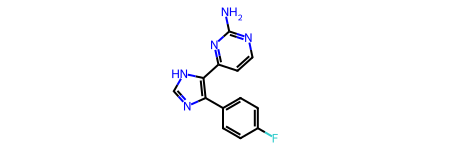

In [25]:
canonical_tautomer_mol = tautomer_enumerator.Canonicalize(kinase_mol)
canonical_tautomer_mol

**Returns the canonical tautomer of a molecule — i.e., a standard, preferred form among its** possible tautomeric structures.
Useful for comparing molecules consistently, removing tautomer-based redundancy

The **TautomerEnumerator** can also generate all possible tautomers for a molecule. We can use a list comprehension to collect all the tautomers.

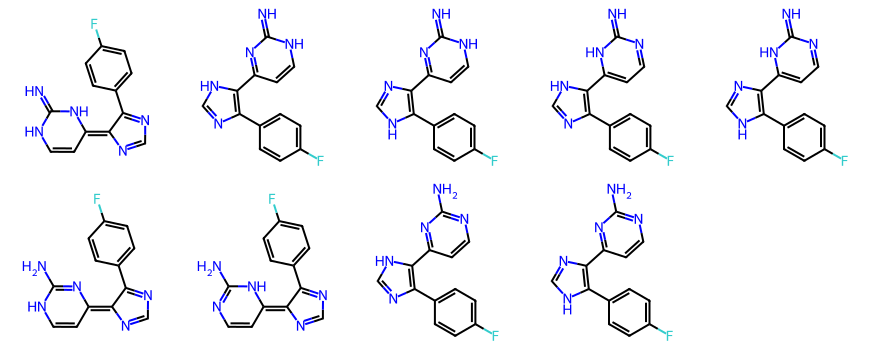

In [26]:
tautomer_list = [x for x in tautomer_enumerator.Enumerate(kinase_mol)]
MolsToGridImage(tautomer_list, molsPerRow=5,subImgSize=(175, 175))

This code generates and visualizes all possible tautomeric forms of a molecule.
The **Enumerate()** function returns a list of tautomers, and **MolsToGridImage()** displays them in a neatly arranged image grid. Useful for visually comparing tautomer structures.